In [7]:
# %matplotlib widget

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table

from itertools import product
from copy import deepcopy as copy
from tqdm import tqdm
from lvmdrp.core.fit_profile import Gaussians
import bottleneck as bn

from lvmdrp import path, __version__ as drpver
from lvmdrp.utils import metadata as md
from lvmdrp.functions import run_drp as drp

from lvmdrp.functions import imageMethod

ORIG_MASTER_DIR = os.getenv("LVM_MASTER_DIR")
MASTER_CON_LAMPS = {"b": "ldls", "r": "ldls", "z": "quartz"}
MASTER_ARC_LAMPS = {"b": "hgne", "r": "neon", "z": "neon"}


f = np.sqrt(2 * np.pi)
def gaussians(pars, x):
    y = pars[0][:, None] * np.exp(-0.5 * ((x[None, :] - pars[1][:, None]) / pars[2][:, None]) ** 2) / (pars[2][:, None] * f)
    return np.sum(y, axis=0)

In [8]:
# # create region files for fiber locations at column 2000
# _create_peaks_regions(fibermap=Table(drp.fibermap.data), column=2000)

In [9]:
frames_table = md.get_metadata(tileid="*", mjd=60177)
frames_table.query("imagetyp == 'bias' | imagetyp == 'dark' | imagetyp == 'flat' | imagetyp == 'arc'", inplace=True)

[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/raw_metadata.hdf5
[INFO]: found 579 frames in store '/home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/raw_metadata.hdf5'
[INFO]: number of frames after filtering 579
[INFO]: total number of frames found 579


In [10]:
masters_mjd = frames_table.mjd.min()
masters_path = os.path.join(ORIG_MASTER_DIR, f"{masters_mjd}")

In [11]:
masters_flat = md.get_metadata(kind="master", imagetyp="flat").query("mjd == @masters_mjd").sort_values("camera")
masters_flat

[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/master_metadata.hdf5
[INFO]: found 147 frames in store '/home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/master_metadata.hdf5'
[INFO]: filtering by imagetyp = 'flat'
[INFO]: number of frames after filtering 18
[INFO]: total number of frames found 18


,tileid,mjd,rmjd,imagetyp,spec,camera,exptime,neon,hgne,krypton,...,argon,ldls,quartz,quality,qual,stage,status,drpqual,nframes,name
12,1111,60177,60177,flat,sp1,b1,150.0,False,False,False,...,False,True,False,excellent,0,1,0,0,2,lvm-mflat_ldls-b1
14,1111,60177,60177,flat,sp2,b2,150.0,False,False,False,...,False,True,False,excellent,0,1,0,0,2,lvm-mflat_ldls-b2
10,1111,60177,60177,flat,sp3,b3,150.0,False,False,False,...,False,True,False,excellent,0,1,0,0,2,lvm-mflat_ldls-b3
16,1111,60177,60177,flat,sp1,r1,150.0,False,False,False,...,False,True,False,excellent,0,1,0,0,2,lvm-mflat_ldls-r1
11,1111,60177,60177,flat,sp2,r2,150.0,False,False,False,...,False,True,False,excellent,0,1,0,0,2,lvm-mflat_ldls-r2
15,1111,60177,60177,flat,sp3,r3,150.0,False,False,False,...,False,True,False,excellent,0,1,0,0,2,lvm-mflat_ldls-r3
13,1111,60177,60177,flat,sp1,z1,10.0,False,False,False,...,False,False,True,excellent,0,1,0,0,2,lvm-mflat_quartz-z1
9,1111,60177,60177,flat,sp2,z2,10.0,False,False,False,...,False,False,True,excellent,0,1,0,0,2,lvm-mflat_quartz-z2
17,1111,60177,60177,flat,sp3,z3,10.0,False,False,False,...,False,False,True,excellent,0,1,0,0,2,lvm-mflat_quartz-z3


[INFO]: using flat image lvm-mflat_ldls-b1.fits for tracing
[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: 0.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|####

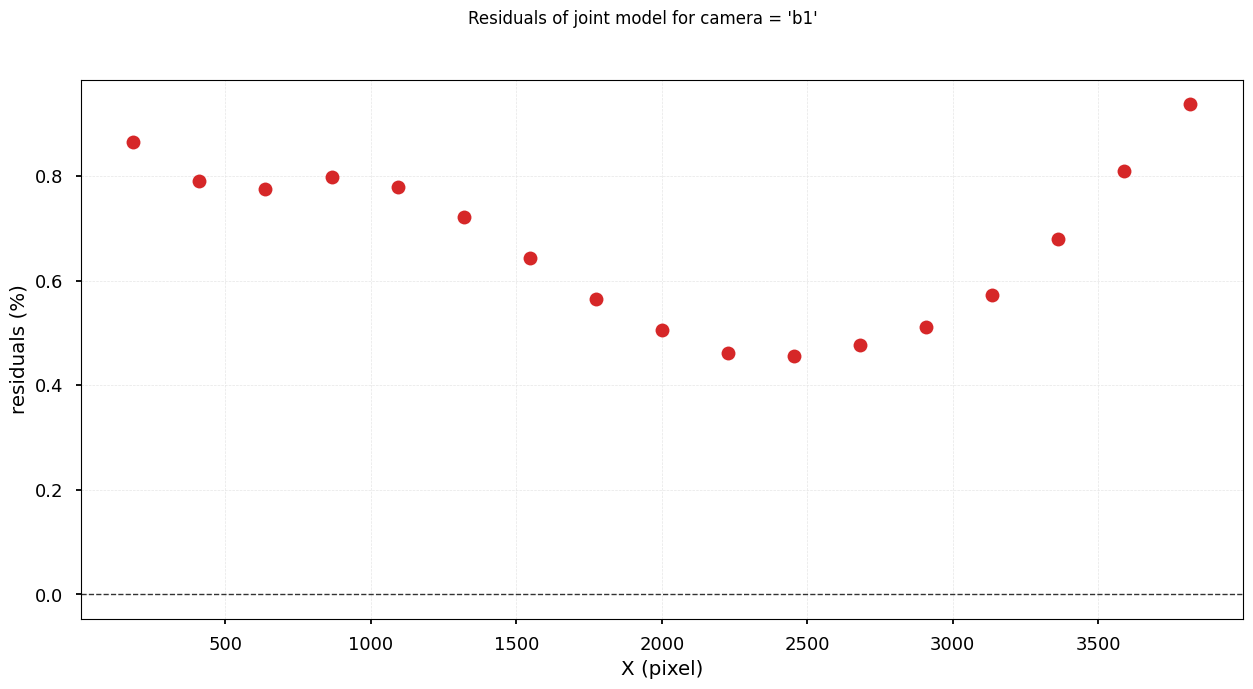

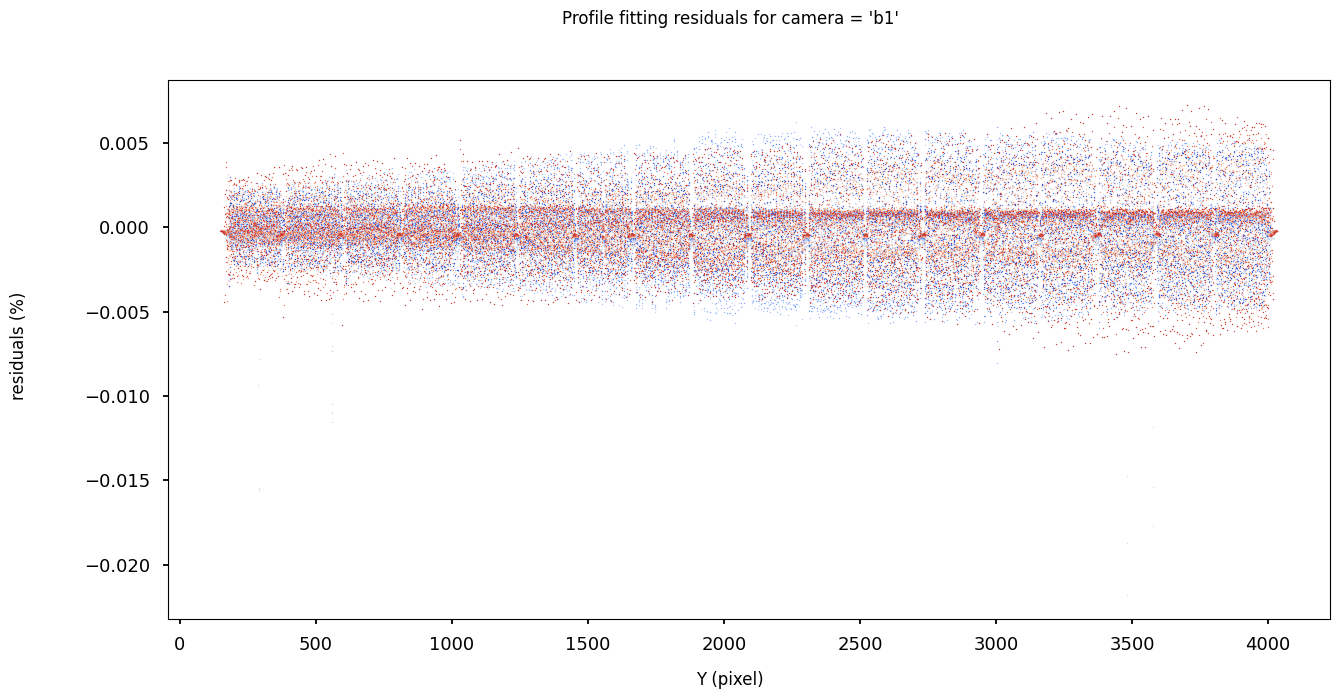

[INFO]: using flat image lvm-mflat_ldls-b2.fits for tracing
[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: 3.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|####

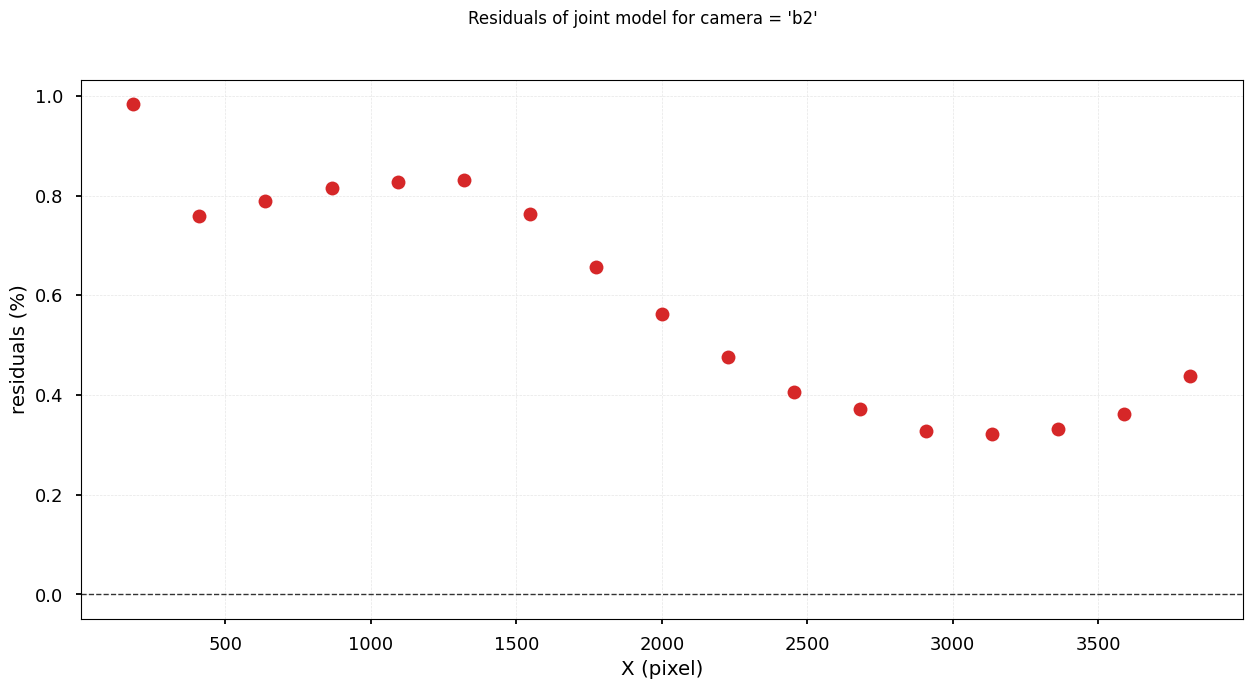

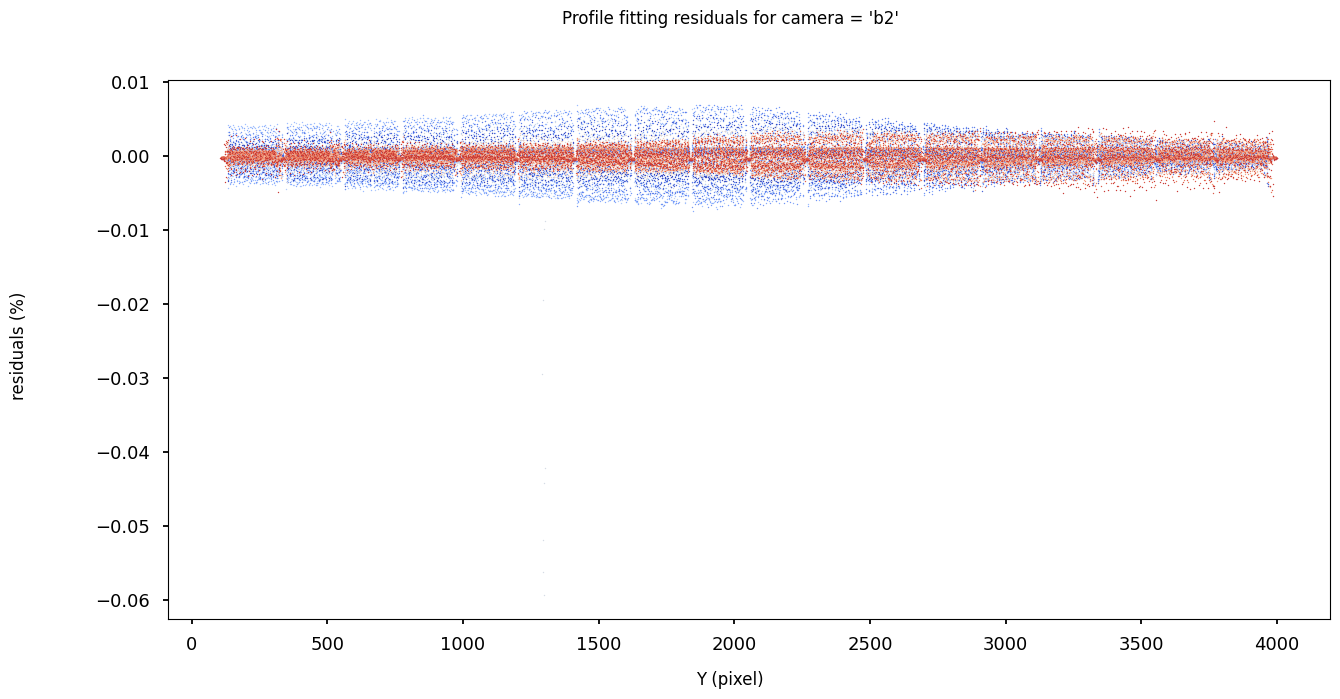

[INFO]: using flat image lvm-mflat_ldls-b3.fits for tracing
[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: -1.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|###

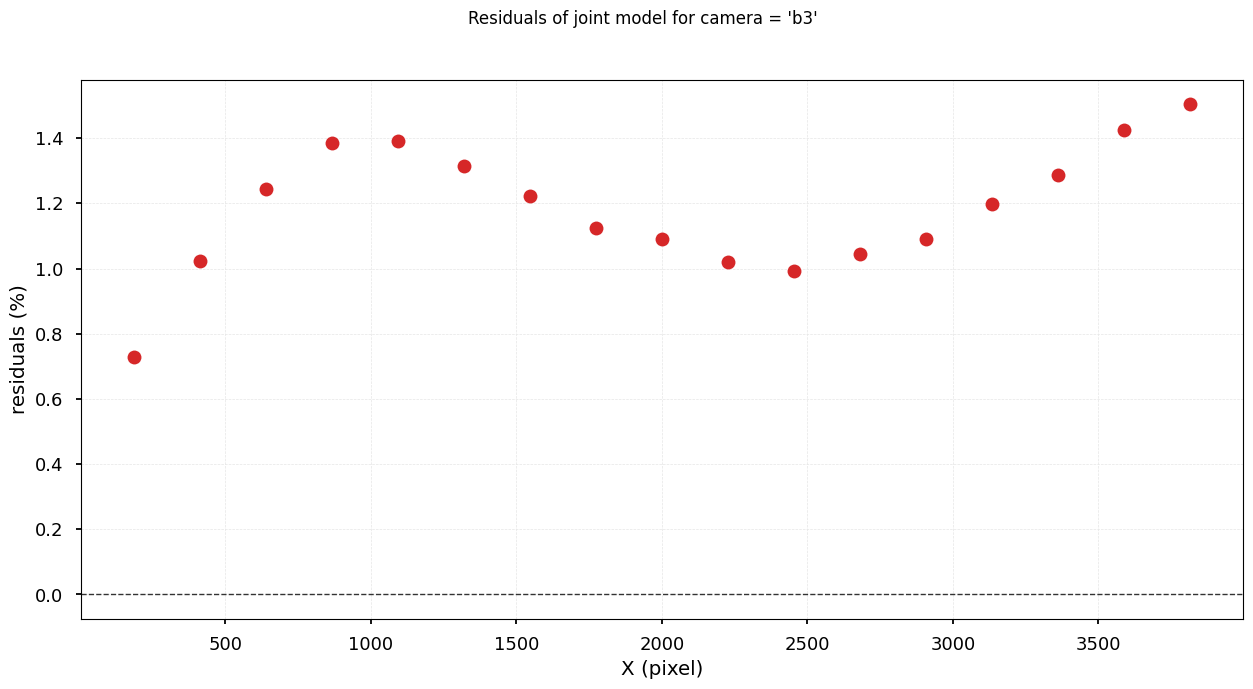

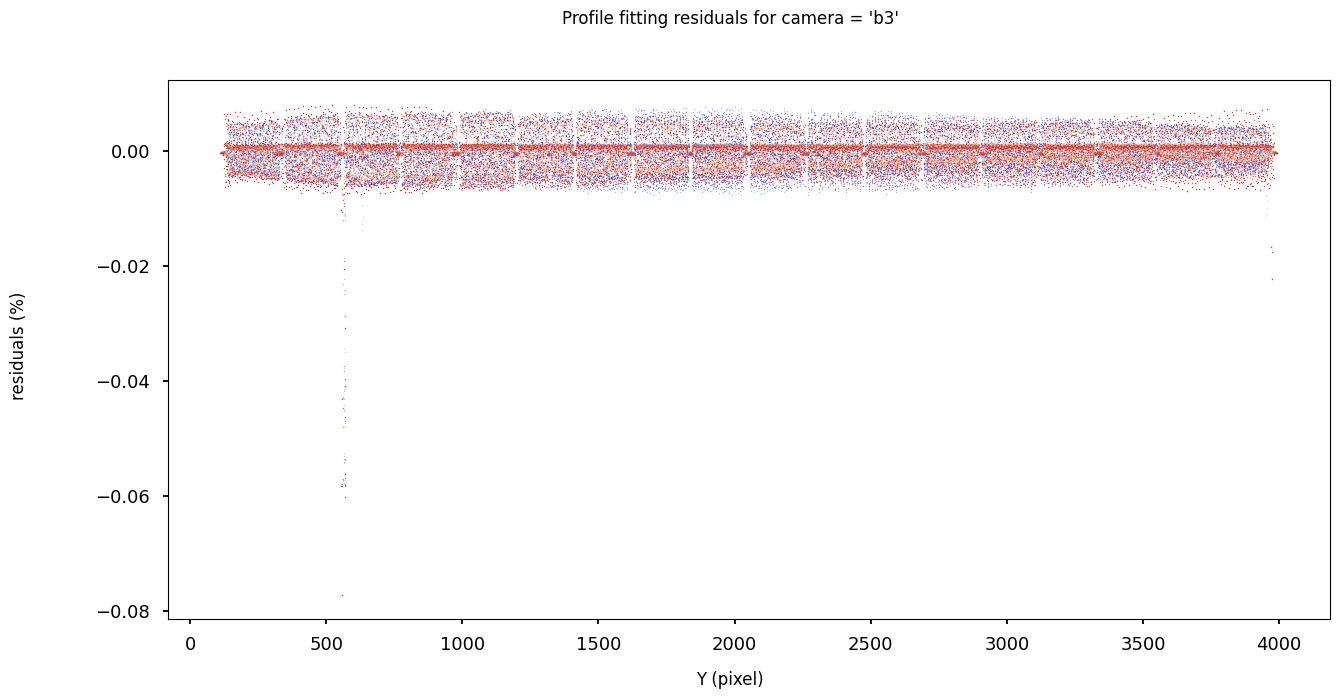

[INFO]: using flat image lvm-mflat_ldls-r1.fits for tracing
[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: -1.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|###

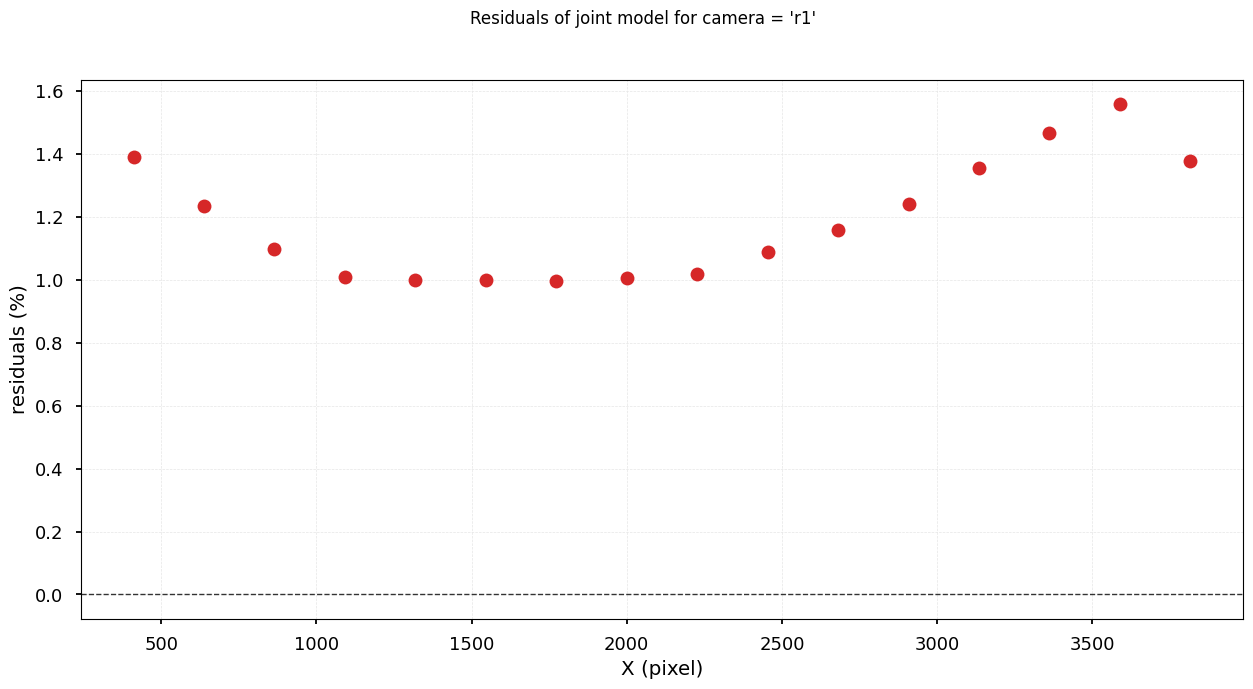

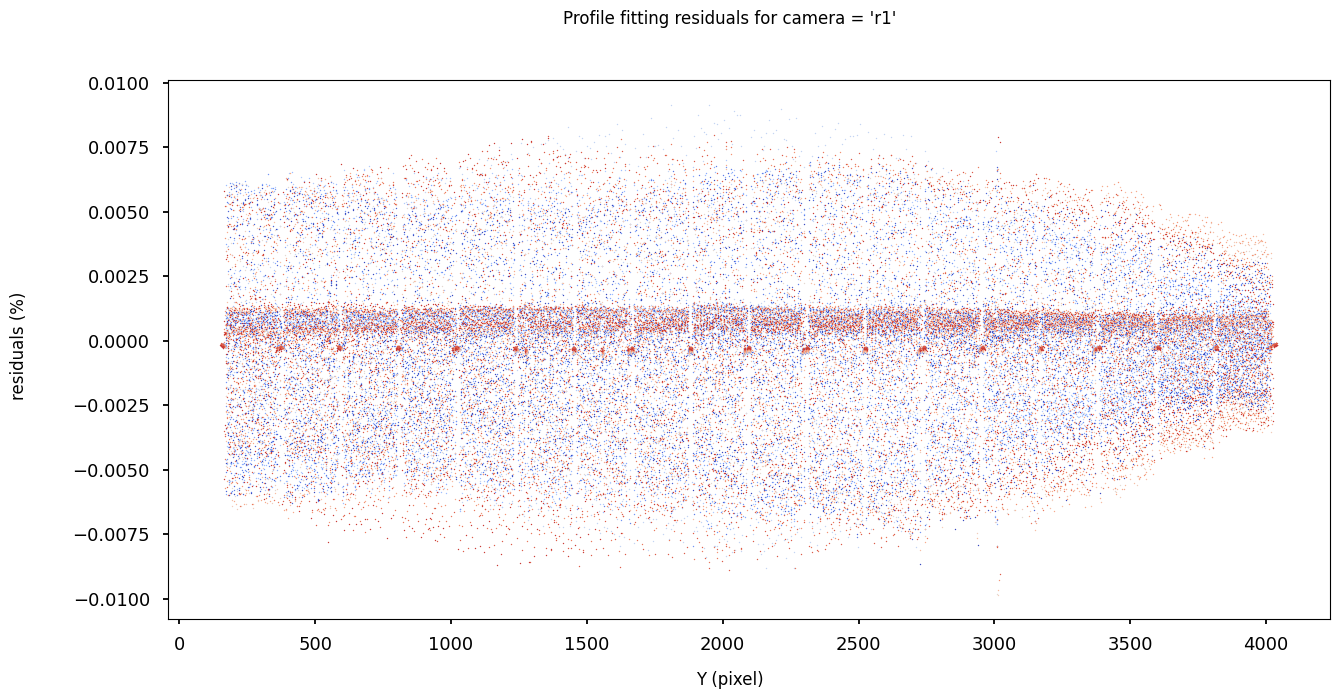

[INFO]: using flat image lvm-mflat_ldls-r2.fits for tracing
[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: 0.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|####

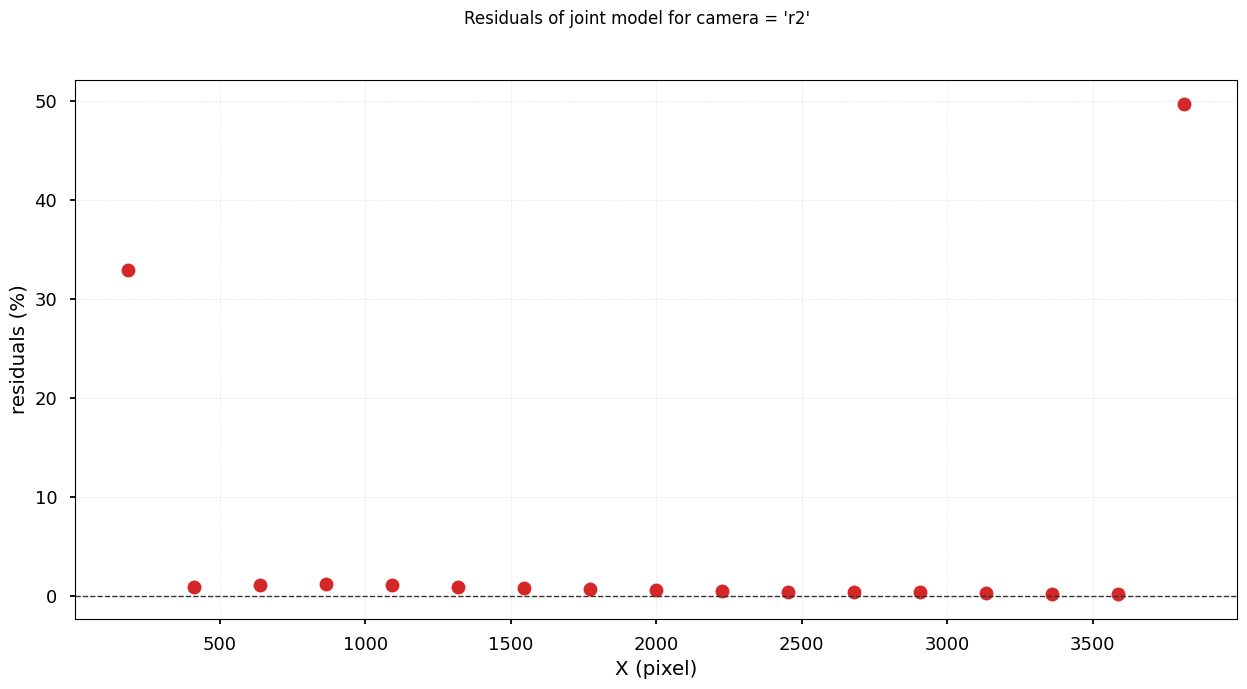

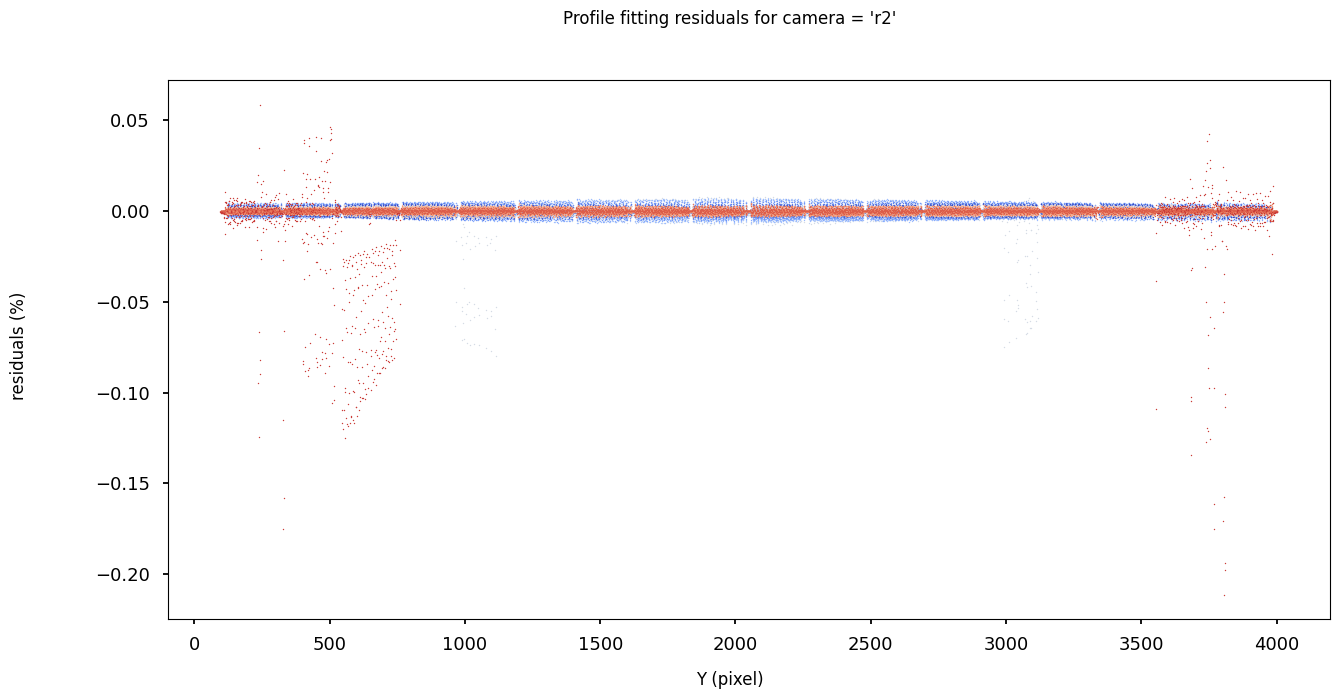

[INFO]: using flat image lvm-mflat_ldls-r3.fits for tracing
[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: -1.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|###

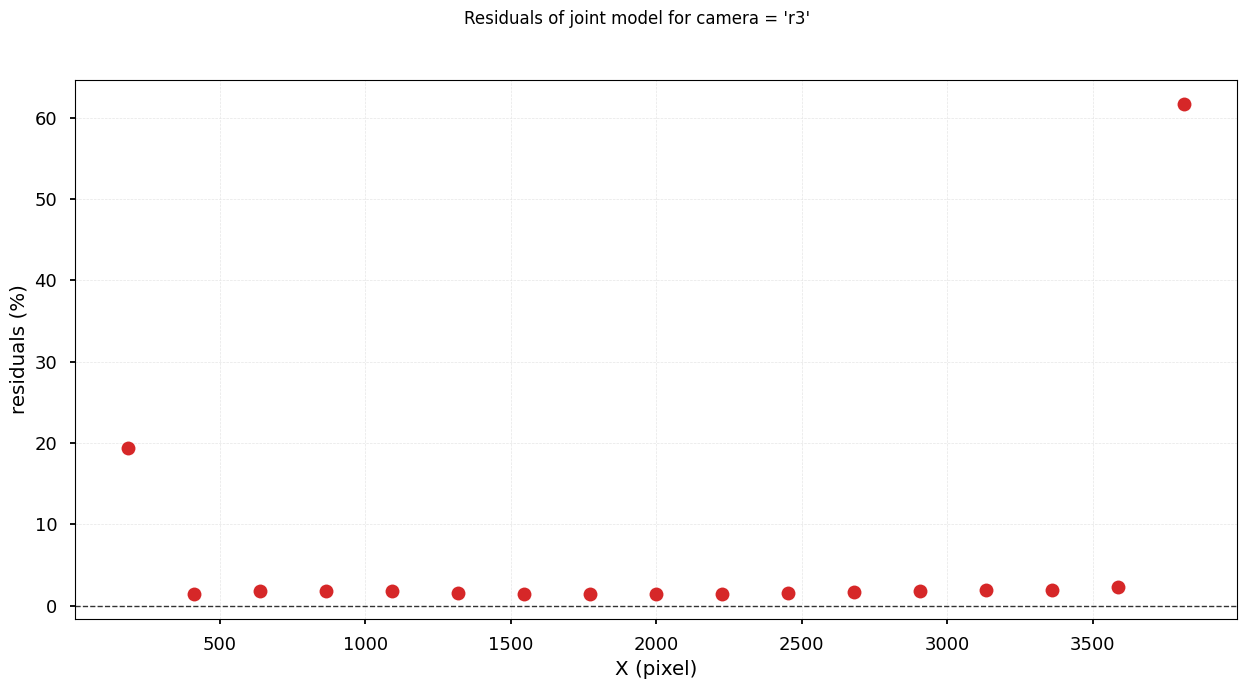

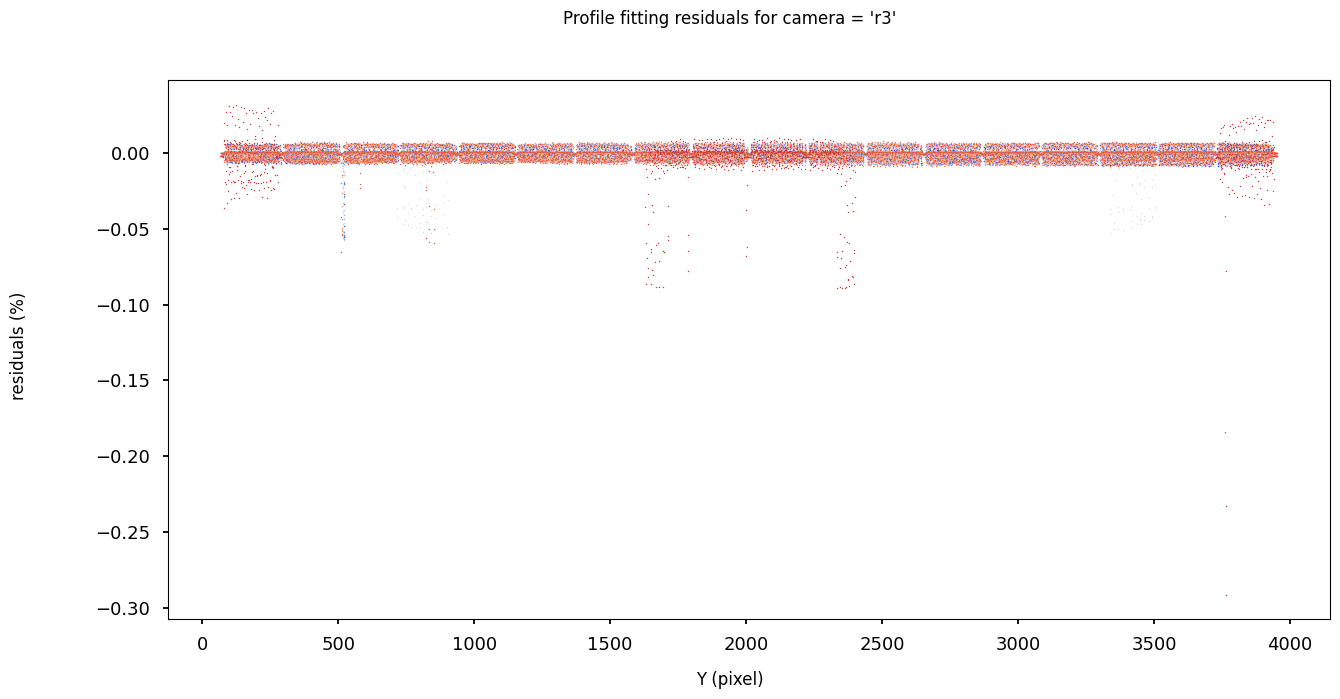

[INFO]: using flat image lvm-mflat_quartz-z1.fits for tracing
[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: 0.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##

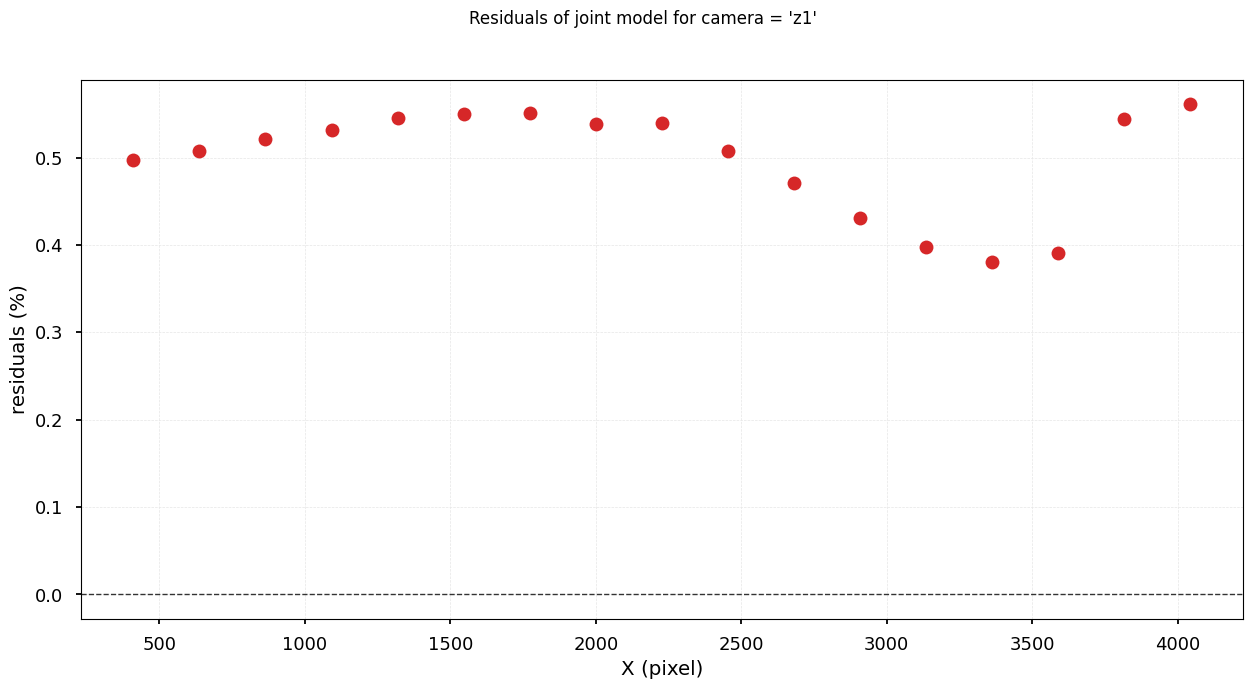

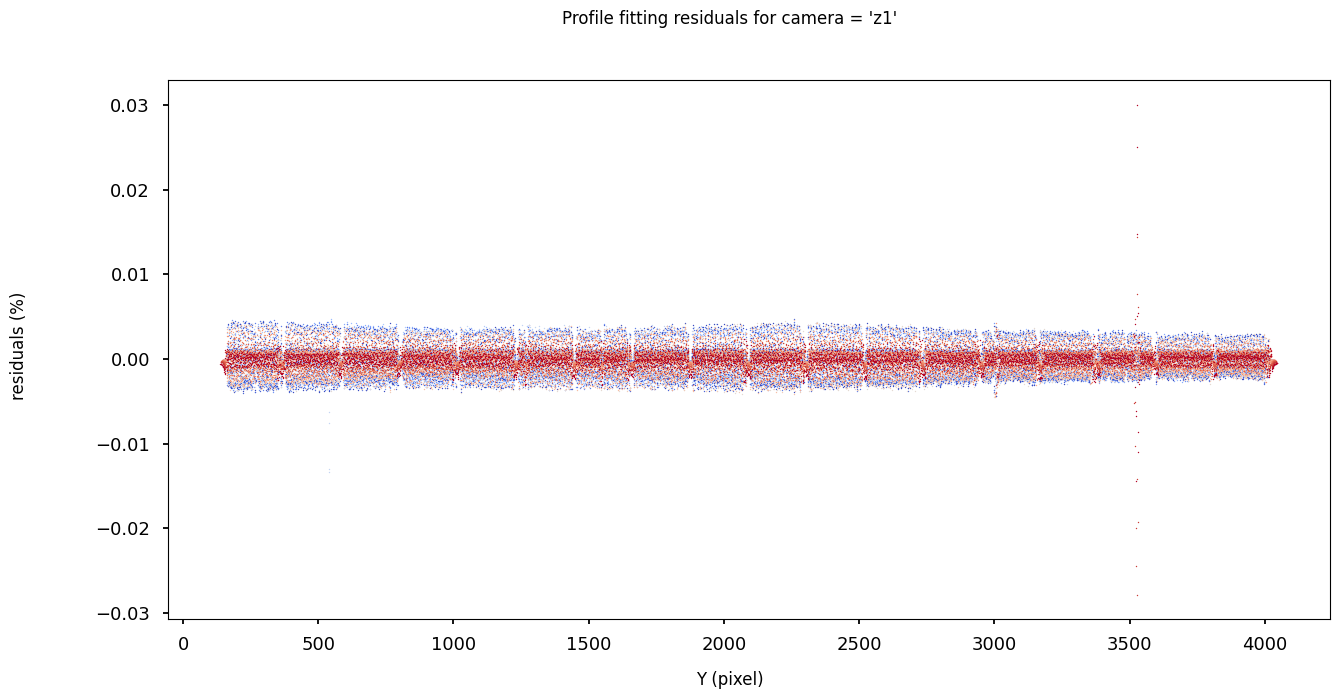

[INFO]: using flat image lvm-mflat_quartz-z2.fits for tracing
[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: 0.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##

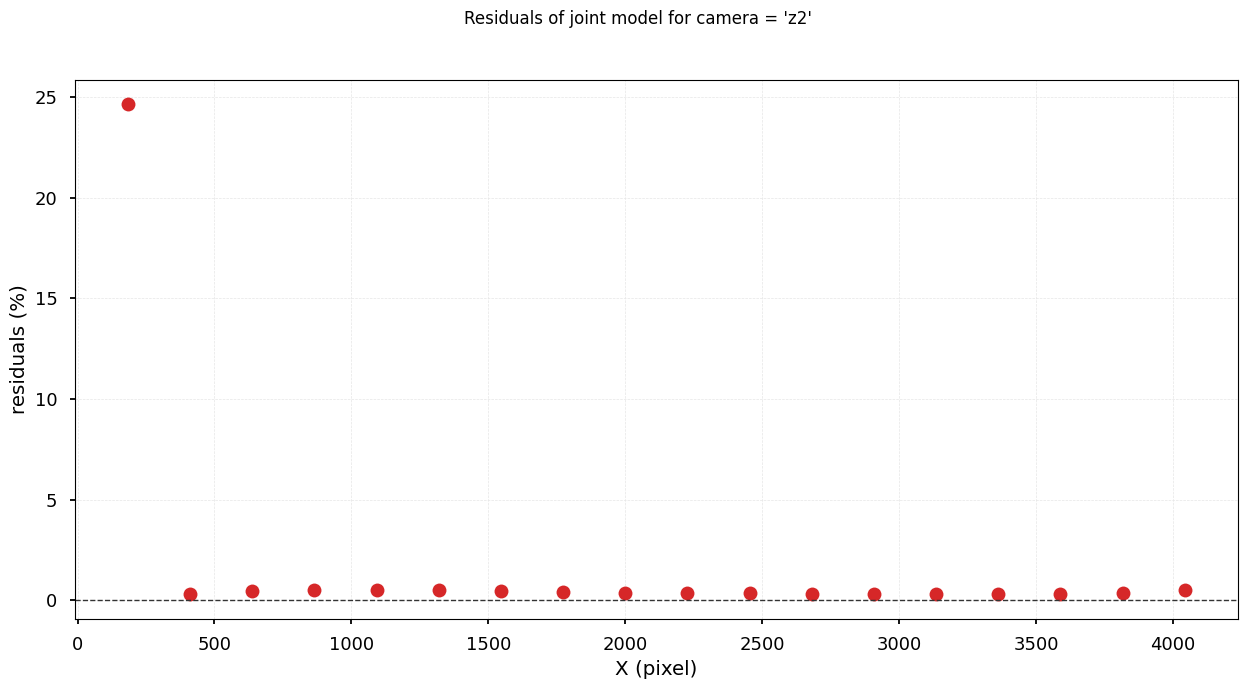

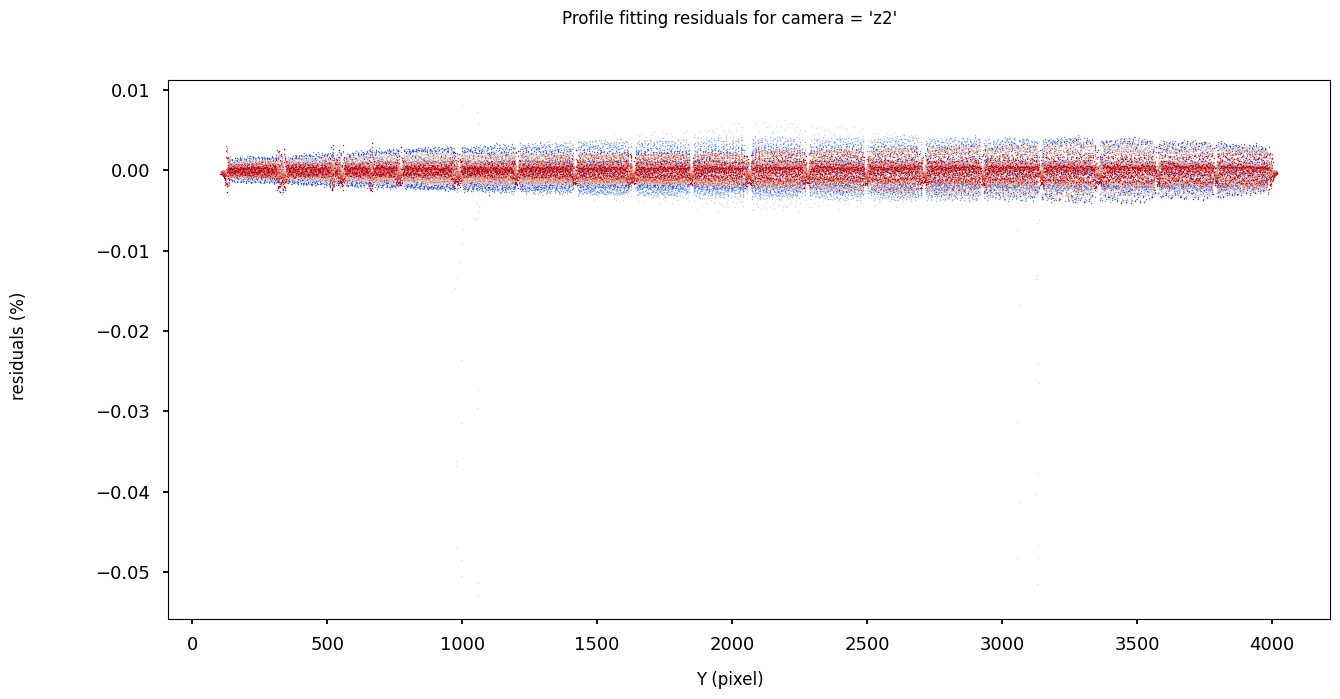

[INFO]: using flat image lvm-mflat_quartz-z3.fits for tracing
[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 5 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.000, shift: 0.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##

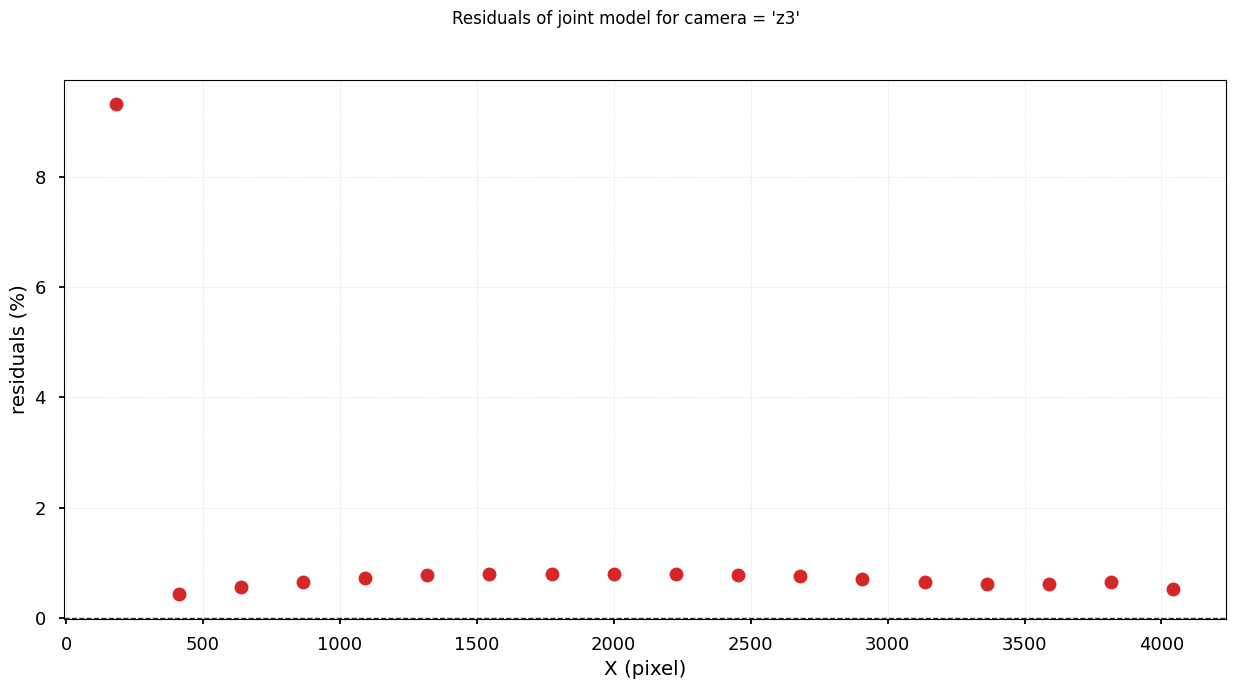

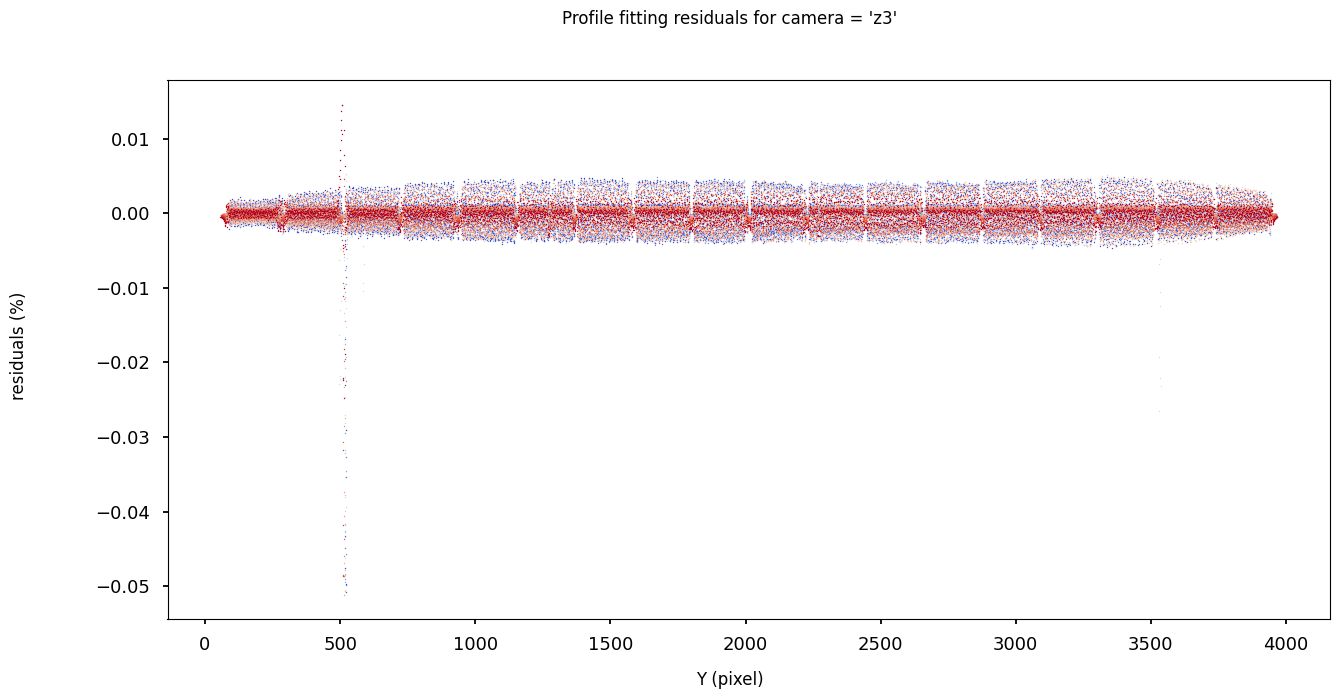

[INFO]: going to extract metadata from 27 frames
extracting metadata: 100%|##########| 27/27 [00:00<00:00, 208.02frame/s]
[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/raw_metadata.hdf5
[INFO]: updating metadata store for tileid = 1111 and mjd = 60177 with 0 new rows
[INFO]: final number of rows 579
[INFO]: writing raw metadata store to disk
[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/master_metadata.hdf5
[INFO]: updating metadata store for masters with 0 new rows
[INFO]: final number of rows 147
[INFO]: writing master metadata store to disk


In [ ]:
mtrace_paths = []
traces = {}
for flat in masters_flat.to_dict("records"):
    camera = flat["camera"]

    lamp = MASTER_CON_LAMPS[camera[0]]
    if lamp == "ldls":
        counts_threshold = 20
    elif lamp == "quartz":
        counts_threshold = 1000

    # define master continuum exposure path
    mflat_path = path.full("lvm_master", drpver=drpver, tileid=flat["tileid"], mjd=masters_mjd, kind=f"mflat_{lamp}", camera=camera)
    # define master trace path
    mtrace_amp_path = os.path.join(masters_path, f"lvm-mtrace_amp-{camera}.fits")
    mtrace_cent_path = os.path.join(masters_path, f"lvm-mtrace_cent-{camera}.fits")
    mtrace_fwhm_path = os.path.join(masters_path, f"lvm-mtrace_fwhm-{camera}.fits")
    mtrace_paths.extend([mtrace_amp_path, mtrace_cent_path, mtrace_fwhm_path])

    # if os.path.isfile(mtrace_fwhm_path):
    #     print(f"skipping {mtrace_fwhm_path}, file already exist")
    #     continue

    # trace peak of fibers
    centroids, trace_cent, trace_flux, trace_fwhm = imageMethod.trace_fibers(
        in_image=mflat_path,
        out_trace_amp=mtrace_amp_path, out_trace_cent=mtrace_cent_path, out_trace_fwhm=mtrace_fwhm_path, out_trace_cent_guess=None,
        correct_ref=True, median_box=(1,10), coadd=5,
        counts_threshold=counts_threshold, max_diff=1.5, method="gauss",
        ncolumns=(140, 40), nblocks=18,
        fit_poly=False, poly_deg=(4, 4, 3), display_plots=True
    )
    traces[camera] = {"centroids": centroids, "trace_cent": trace_cent, "trace_flux": trace_flux, "trace_fwhm": trace_fwhm}

    # # evaluate continuum exposure model
    # img = imageMethod.loadImage(mflat_path)
    # mod = copy(img)

    # column = np.arange(img._dim[0])
    # for icolumn in tqdm(range(img._dim[1]), desc="evaluating Gaussians", unit="column", ascii=True):
    #     pars = (trace_flux_fit._data[:, icolumn], trace_cent_fit._data[:, icolumn], trace_fwhm_fit._data[:, icolumn] / 2.354)

    #     mod._data[:, icolumn] = gaussians(pars=pars, x=column)

    # # save model and model to data ratio
    # mmod_path = os.path.join(masters_path, f"lvm-mmod-{camera}.fits")
    # mrat_path = os.path.join(masters_path, f"lvm-mrat-{camera}.fits")
    # mod.writeFitsData(mmod_path)
    # (mod / img).writeFitsData(mrat_path)

# cache new masters metadata into HDF5 files
new_masters = md.extract_metadata(frames_paths=mtrace_paths)
md.add_masters(new_masters)

In [1]:
from lvmdrp.functions import rssMethod


SLITMAP = Table(drp.fibermap.data)

# camera = "z3"
trace = traces[camera]["trace_cent"]

fibermap = SLITMAP[SLITMAP["spectrographid"] == int(camera[1])]
select = fibermap["telescope"] == "Spec"
con_lamp = MASTER_CON_LAMPS[camera[0]]


ifibers = np.where(select)[0]
for idx in ifibers:
    plt.figure(figsize=(15, 5))
    plt.plot(trace._data[idx], color="r", label=fibermap[idx]["orig_ifulabel"])
    plt.plot(trace._data[idx+1], color="k", label=fibermap[idx+1]["orig_ifulabel"])
    plt.plot(trace._data[idx-1], color="k", label=fibermap[idx-1]["orig_ifulabel"])
    plt.title(f"{camera}")
    plt.legend(loc=2)


[ERROR]: Traceback (most recent call last):
  File "/Users/amejia/.local/bin/miniconda3/envs/lvmdrp/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/_m/qjst344n07740mgj9t91t4k80000gn/T/ipykernel_53548/4184765128.py", line 4, in <module>
    SLITMAP = Table(drp.fibermap.data)
NameError: name 'Table' is not defined



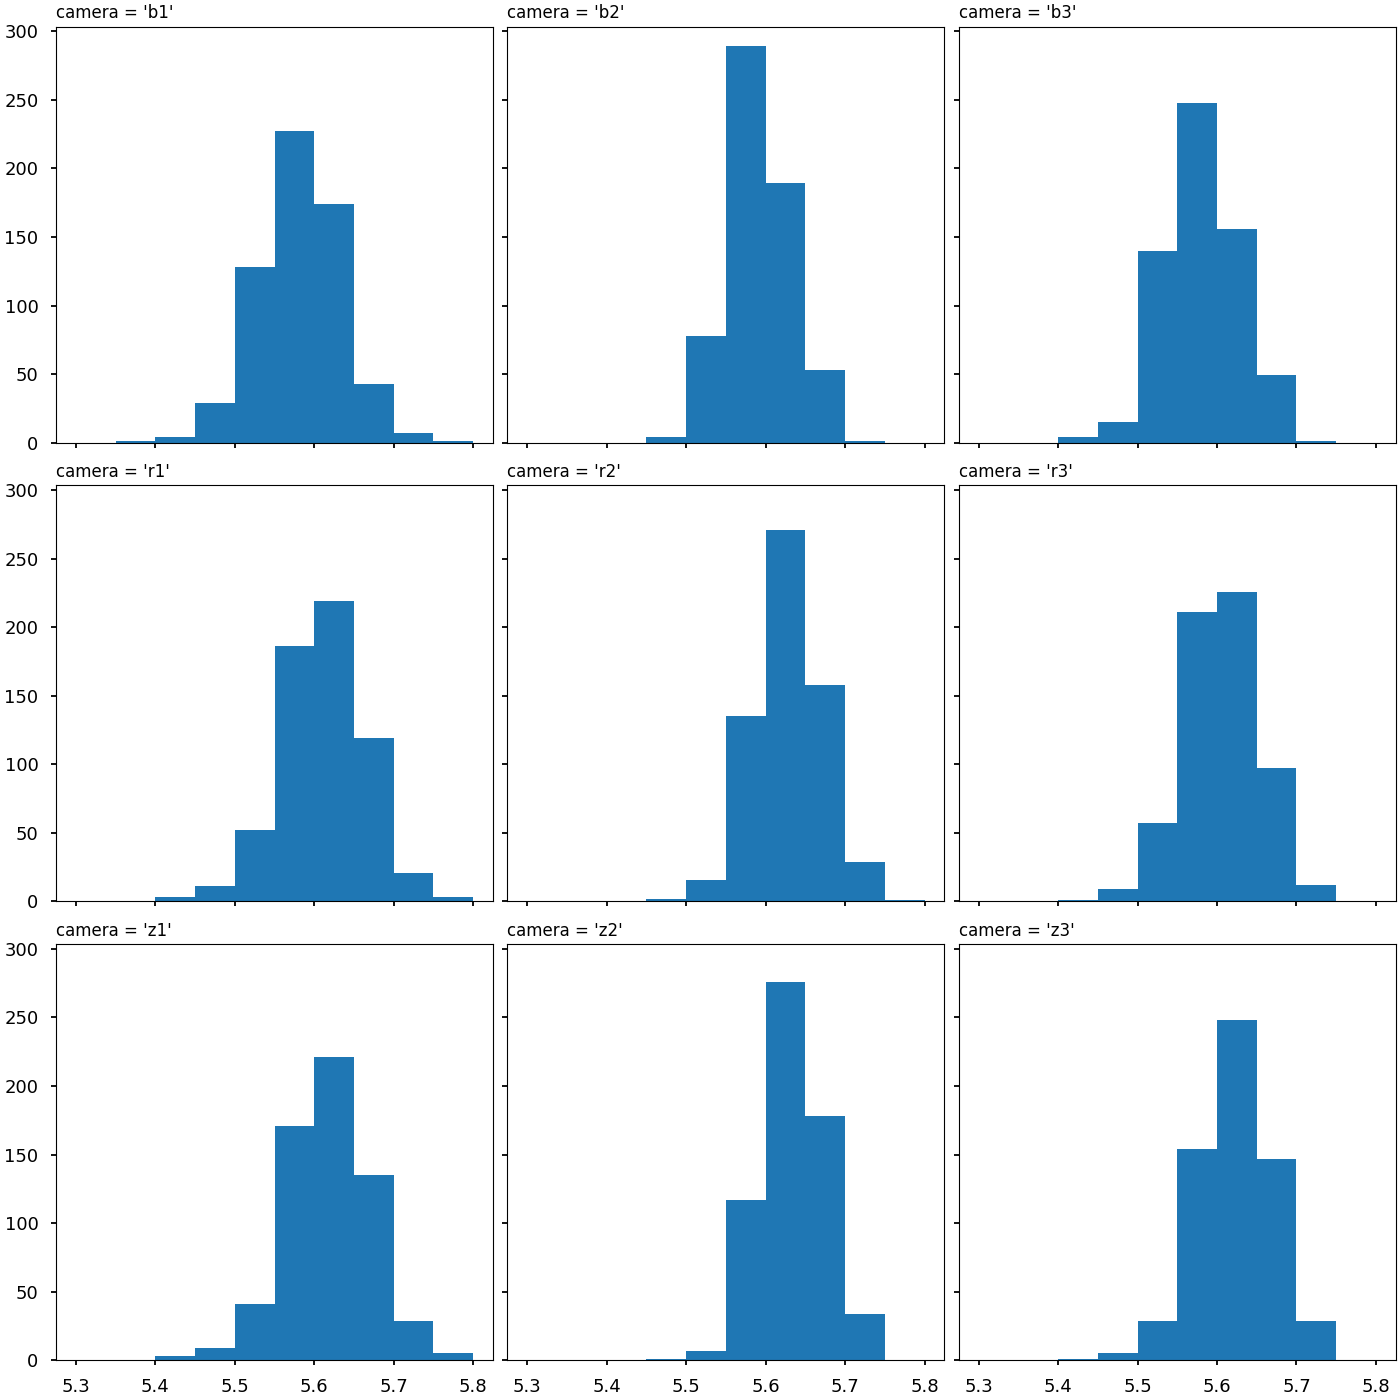

In [2]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt

from lvmdrp.core.tracemask import TraceMask
from lvmdrp import main as drp


fibers = drp.get_calib_paths(mjd=60255, version="1.1.2dev", flavors={"trace", "amp", "width", "model"})

fig, axs = plt.subplots(3, 3, figsize=(14,14), sharex=True, sharey=True, layout="constrained")
axs = axs.ravel()
for i, camera in enumerate(drp.CAMERAS):
    cent = TraceMask.from_file(fibers["trace"][camera])
    fiber_dist = np.gradient(cent._data[::-1], axis=0)

    axs[i].set_title(f"{camera = }", loc="left", fontsize="large")
    axs[i].hist(fiber_dist[:, 2000].ravel(), range=(5.3, 5.8), bins=10)

(2017.2801513671875, 1995.0303955078125)

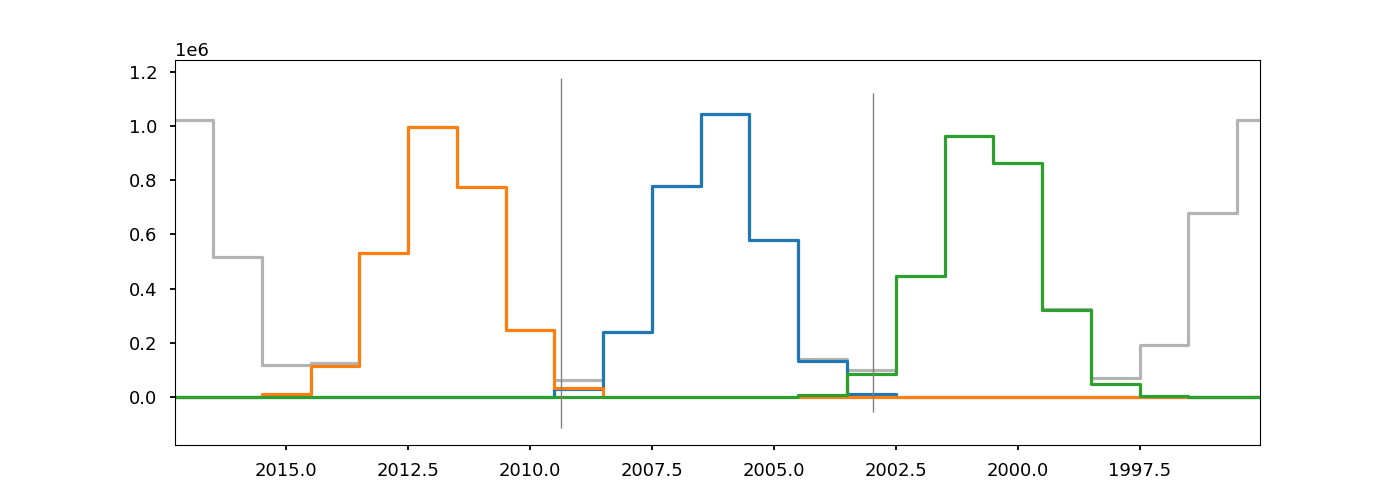

In [9]:
from lvmdrp.core.fit_profile import gaussians
from lvmdrp.core.image import loadImage

camera = "b2"
column = 2000
ifiber = 330

model = loadImage(fibers["model"][camera])
amp = TraceMask.from_file(fibers["amp"][camera])
cent = TraceMask.from_file(fibers["trace"][camera])
width = TraceMask.from_file(fibers["width"][camera])

ypixels = np.arange(model._dim[0])

plt.figure(figsize=(14,5))
plt.step(ypixels, model._data[:, column], where="mid", color="0.7")
plt.step(ypixels, gaussians([amp._data[[ifiber], column], cent._data[[ifiber], column], width._data[[ifiber], column]/2.354], ypixels), where="mid")
plt.step(ypixels, gaussians([amp._data[[ifiber-1], column], cent._data[[ifiber-1], column], width._data[[ifiber-1], column]/2.354], ypixels), where="mid")
plt.step(ypixels, gaussians([amp._data[[ifiber+1], column], cent._data[[ifiber+1], column], width._data[[ifiber+1], column]/2.354], ypixels), where="mid")
plt.vlines(cent._data[ifiber, column]-3*width._data[ifiber, column]/2.354, *plt.gca().get_ylim(), lw=1, color="0.5")
plt.vlines(cent._data[ifiber, column]+3*width._data[ifiber, column]/2.354, *plt.gca().get_ylim(), lw=1, color="0.5")
plt.xlim(cent._data[ifiber-2, column], cent._data[ifiber+2, column])

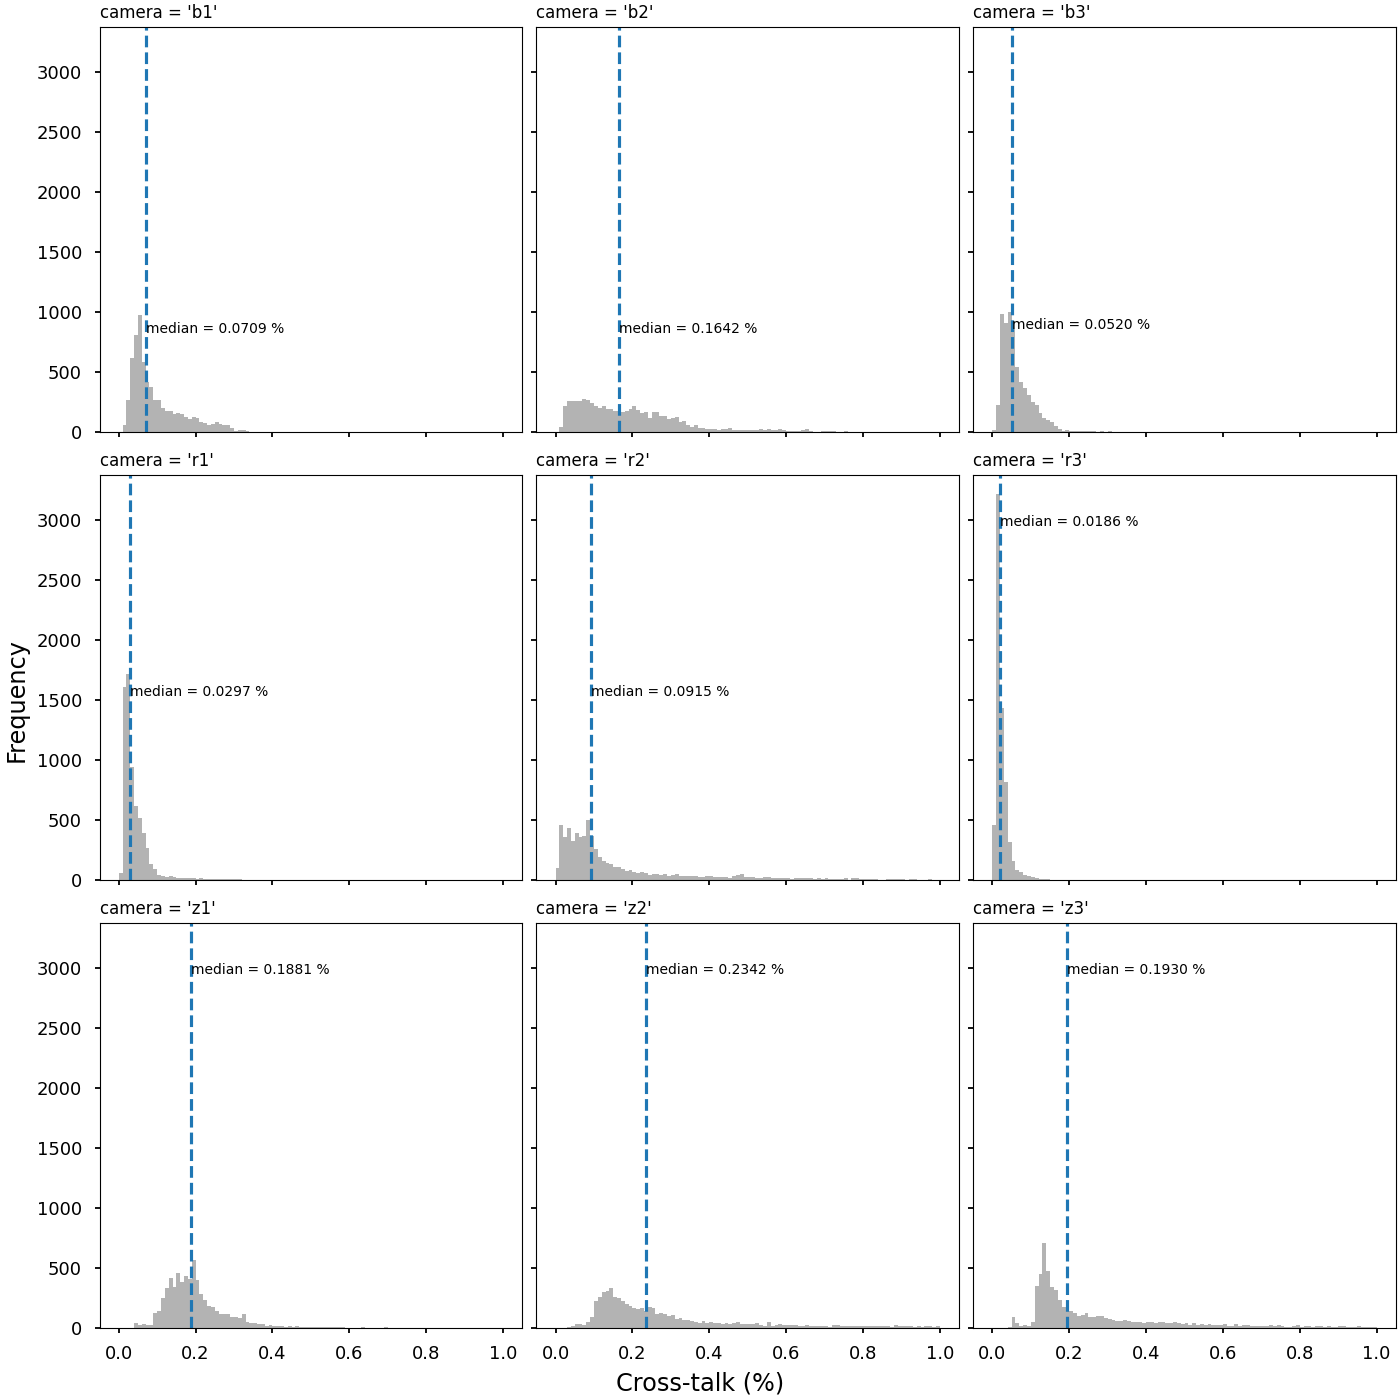

In [12]:
import itertools as it


def _get_crosstalk(cent, fwhm, ifiber, jcolumn, ypixels=None, nfibers=1):
    if ypixels is None:
        ypixels = np.arange(0, 4080)

    ref_cent = cent._data[[ifiber], jcolumn]
    ref_width = fwhm._data[[ifiber], jcolumn] / 2.354
    ref_amp = np.asarray([1.0])
    ref_fiber = gaussians([ref_amp, ref_cent, ref_width], ypixels)

    nei_ifibers = [ifiber - i for i in range(nfibers, 0, -1)] + [ifiber + i for i in range(1, nfibers + 1)]
    nei_cents = cent._data[nei_ifibers, jcolumn]
    nei_widths = fwhm._data[nei_ifibers, jcolumn] / 2.354
    nei_amps = np.ones_like(nei_ifibers)

    nei_fibers = gaussians([nei_amps, nei_cents, nei_widths], ypixels)

    ref_unit = ref_fiber / np.sqrt(np.dot(ref_fiber, ref_fiber))
    crosstalk = np.dot(nei_fibers, ref_unit) * 100

    return crosstalk

fig, axs = plt.subplots(3, 3, figsize=(14,14), sharex=True, sharey=True, layout="constrained")
axs = axs.ravel()
fig.supxlabel("Cross-talk (%)", fontsize="xx-large")
fig.supylabel("Frequency", fontsize="xx-large")
for i, camera in enumerate(drp.CAMERAS):
    cent = TraceMask.from_file(fibers["trace"][camera])
    width = TraceMask.from_file(fibers["width"][camera])

    crosstalks = []
    for ifiber, jcolumn in it.product(range(1, 648-1, 10), range(0, 4086, 40)):
        crosstalks.append(_get_crosstalk(cent, width, ifiber=ifiber, jcolumn=jcolumn))
    med = np.median(crosstalks)

    axs[i].hist(crosstalks, bins=100, range=(0,1), color="0.7")
    axs[i].axvline(med, ls="--", color="tab:blue")
    axs[i].text(med, plt.gca().get_ylim()[1]*0.9, f"median = {med:.4f} %", va="top", ha="left")
    axs[i].set_title(f"{camera = }", loc="left", fontsize="large")


fig.savefig("crosstalk.png")
# fiber_r = gaussians([np.ones_like(amp._data[[ifiber], column]), cent._data[[ifiber], column], width._data[[ifiber], column]/2.354], ypixels)
# fiber_i = gaussians([np.ones_like(amp._data[[ifiber-1], column]), cent._data[[ifiber-1], column], width._data[[ifiber-1], column]/2.354], ypixels)
# fiber_f = gaussians([np.ones_like(amp._data[[ifiber+1], column]), cent._data[[ifiber+1], column], width._data[[ifiber+1], column]/2.354], ypixels)

# plt.figure(figsize=(14,5))
# plt.plot(ypixels, fiber_r)
# plt.plot(ypixels, fiber_i)
# plt.plot(ypixels, fiber_f)
# plt.plot(ypixels, fiber_r*(fiber_i+fiber_f), color="0.8")
# # plt.plot(ypixels, fiber_r*fiber_f*1e3, color="0.8")
# plt.xlim(cent._data[ifiber-2, column], cent._data[ifiber+2, column])

(-10.0, 10.0)

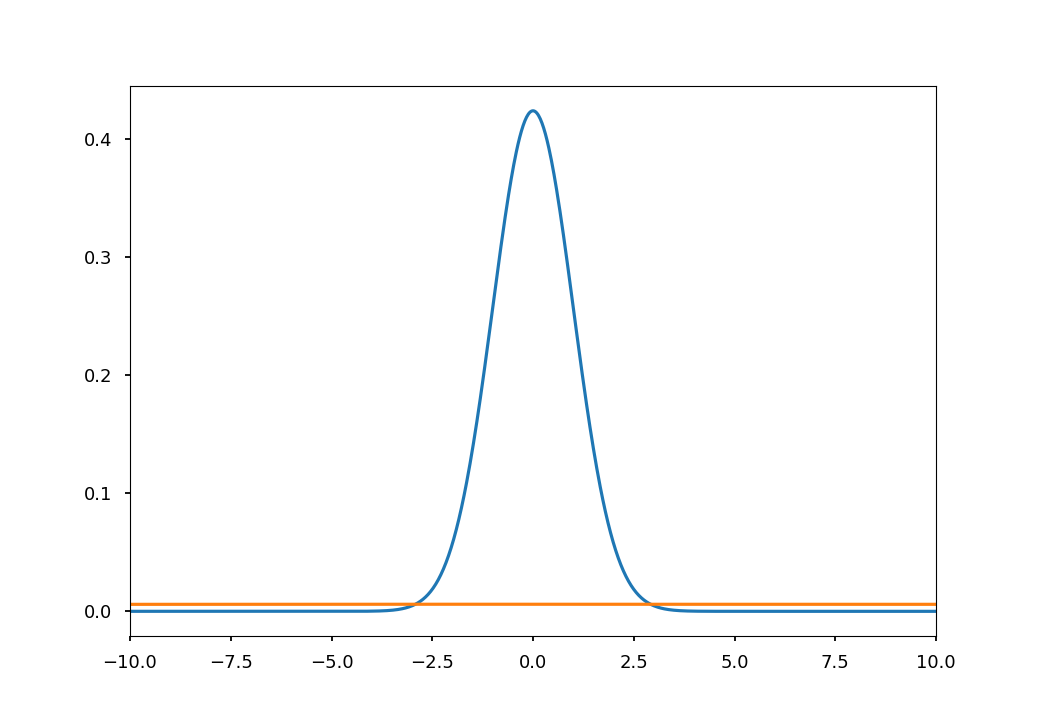

In [ ]:
from scipy.stats import norm
from scipy.signal import correlate, correlation_lags

sigma = 2.5/2.354
gaussian = norm(loc=0, scale=sigma)

x = np.linspace(-10*sigma, +10*sigma, 1000)
y = gaussian.pdf(x)

cc = correlate(y, y, mode="same")
cc_x = correlation_lags(len(y), len(y), mode="same")
cc /= np.trapz(cc, cc_x)

plt.figure()
plt.plot(x, y)
plt.plot(cc_x, cc)
# plt.plot(cc_x, norm.pdf(cc_x, loc=0, scale=np.sqrt(2*sigma**2)))
plt.xlim(-10,10)